In [1]:
!pip install -r requirements.txt

In [2]:
!pip install chardet

In [200]:
!pip install gensim

In [201]:
!pip install openpyxl

# HABERLER VERİSETİNDEKİ MANŞETLERE GÖRE KATEGORİLERİN İSTATİSTİKSEL MAKİNE ÖĞRENMESİ YAKLAŞIMLARI İLE MAKİNEYE ÖĞRETİLMESİ

#### Kütüphaneleri burada tanımlıyoruz.

In [202]:
import pandas as pd
from mintlemon import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)


#### Dataframe yükleme

In [226]:
df = pd.read_csv('data.csv')

In [227]:
df.head()

,Index,Text,Tag
0,0,Tüketmeyi hemen bırakmanız gereken 4 şey,4
1,1,Fabrikada gaz sızıntısı: 36 kişi hastanelik oldu,4
2,2,Gece uyumayanların atardamar tıkanıklığına sah...,4
3,3,Acil servise başvuranların sayısı 2 katına çık...,4
4,4,Prim borcu olan GSS'liler 2024'te sağlık hizme...,4


#### Preprocessing - Veri Önişleme aşaması

   - Bu aşamada önce boş veri var mı kontrol ederiz ve varsa kaldırırız.
   - Daha sonra önişleme işlemlerinin tamamı için *Nane&Limon* ekibinin oluşturduğu https://mintlemon-turkish-nlp.readthedocs.io/en/latest/_module/normalizer.html kütüphanesini kullandık. Kolayca koda entegre edebiliriz.

In [228]:
df.isnull().sum()

Index    0
Text     0
Tag      0
dtype: int64

In [229]:
df.dropna(inplace=True)
df.isnull().sum()

Index    0
Text     0
Tag      0
dtype: int64

In [230]:
df['Text'] # Boş verileri attıktan sonra temizleme öncesi duruma baktık.

0                Tüketmeyi hemen bırakmanız gereken 4 şey
1        Fabrikada gaz sızıntısı: 36 kişi hastanelik oldu
2       Gece uyumayanların atardamar tıkanıklığına sah...
3       Acil servise başvuranların sayısı 2 katına çık...
4       Prim borcu olan GSS'liler 2024'te sağlık hizme...
                              ...                        
3265    ATO Yönetim Kurulu Başkan Yardımcısı Halil İbr...
3266    Yeni Varlık Yönetim Şirketi BLG Varlık Yönetim...
3267    Ege İhracatçı Birlikleri, Ekim Ayında İhracatı...
3268    Haziran Enflasyonu: Kira ve Doğal Gaz Fiyatlar...
3269             TCMB, reeskont faiz oranlarını yükseltti
Name: Text, Length: 3270, dtype: object

##### Adım adım:
##### 1 - remove_stopwords --> Stopwords kaldırıldı.
##### 2 - remove_numbers --> Rakamlar kaldırıldı.
##### 3 - remove_punctuations --> Her türlü noktalama işareti kaldırıldı.
##### 4 - lower_case --> Tüm veri küçük harfe çevrildi.

**Ref: https://pypi.org/project/mintlemon-turkish-nlp/**

In [231]:
#df['Text'] = df['Text'].apply(Normalizer.remove_stopwords)
df['Text'] = df['Text'].apply(Normalizer.remove_numbers)
df['Text'] = df['Text'].apply(Normalizer.remove_punctuations)
df['Text'] = df['Text'].apply(Normalizer.lower_case)

In [232]:
df['Text'] # Temizleme sonrası durumu kontrol ettik.

0                  tüketmeyi hemen bırakmanız gereken şey
1            fabrikada gaz sızıntısı kişi hastanelik oldu
2       gece uyumayanların atardamar tıkanıklığına sah...
3       acil servise başvuranların sayısı katına çıktı...
4       prim borcu olan gssliler te sağlık hizmeti ala...
                              ...                        
3265    ato yönetim kurulu başkan yardımcısı halil ibr...
3266    yeni varlık yönetim şirketi blg varlık yönetim...
3267    ege ihracatçı birlikleri ekim ayında ihracatın...
3268    haziran enflasyonu kira ve doğal gaz fiyatları...
3269              tcmb reeskont faiz oranlarını yükseltti
Name: Text, Length: 3270, dtype: object

preprocessing sonrası mutlaka tekrar boş veri olup olmadığı kontrol edilmelidir.

In [233]:
df.isnull().sum()

Index    0
Text     0
Tag      0
dtype: int64

In [234]:
df.groupby('Tag')['Text'].nunique().reset_index() # Hangi etiketten kaç veri var? Her sınıftan yaklaşık eşit sayıda veri olması sınıflandırma başarısı için önemlidir.

,Tag,Text
0,0,500
1,1,500
2,2,500
3,3,501
4,4,501
5,5,501


In [235]:
X=df["Text"]
y=df["Tag"]

In [236]:
X

0                  tüketmeyi hemen bırakmanız gereken şey
1            fabrikada gaz sızıntısı kişi hastanelik oldu
2       gece uyumayanların atardamar tıkanıklığına sah...
3       acil servise başvuranların sayısı katına çıktı...
4       prim borcu olan gssliler te sağlık hizmeti ala...
                              ...                        
3265    ato yönetim kurulu başkan yardımcısı halil ibr...
3266    yeni varlık yönetim şirketi blg varlık yönetim...
3267    ege ihracatçı birlikleri ekim ayında ihracatın...
3268    haziran enflasyonu kira ve doğal gaz fiyatları...
3269              tcmb reeskont faiz oranlarını yükseltti
Name: Text, Length: 3270, dtype: object

In [237]:
y

0       4
1       4
2       4
3       4
4       4
       ..
3265    5
3266    5
3267    5
3268    5
3269    5
Name: Tag, Length: 3270, dtype: int64

#### Vektörleştirme - Vectorization 

Temizlediğimiz verinin ise matematiksel bir anlam içermesi gerekir ki modellenebilsin. Bu yüzden TfidfVectorizer kullandık.

In [238]:
def vectorize(data, tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return X_tfidf_df

In [239]:
tfidf_vect = TfidfVectorizer()
tfidf_vect_fit=tfidf_vect.fit(df['Text'])

In [240]:
X=vectorize(X,tfidf_vect_fit)

In [241]:
X

,aadaylığını,aadayı,aaktüel,ab,abartısız,abb,abbvie,abd,abdde,abdden,...,şutla,şükür,şüpheli,şüphelisi,şüphesi,şüpheye,şık,şırnak,şırnakta,şırnaktaki
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tüm veriyi train ve test olarak split ettirdik.

In [242]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=42, test_size=20)

#### Modelleme

In [243]:
rf1=RandomForestClassifier()
rf1.fit(x_train, y_train)

RandomForestClassifier()

In [244]:
y_pred = rf1.predict(x_test)

In [246]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted'
recall = recall_score(y_test, y_pred, average='macro')        # or 'micro', 'weighted'
f1 = f1_score(y_test, y_pred, average='macro')   

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5
Precision: 0.6349206349206349
Recall: 0.5416666666666666
F1 Score: 0.4694444444444444


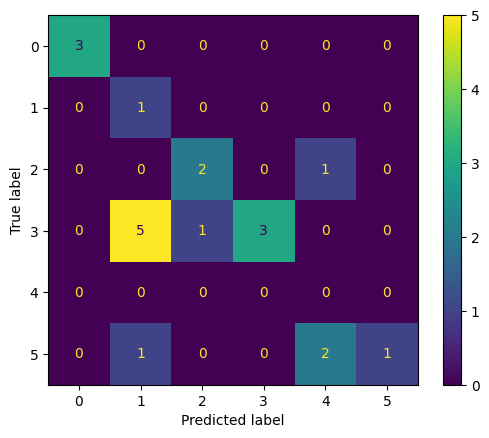

In [247]:
# Karmaşıklık matrisinin oluşturulması
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Cross Validation kullanarak yaparsak aşağıdaki gibi olur.

In [250]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

rf2 = RandomForestClassifier()

# Özel ortalama metodları ile özel değerlendirmelerin tanımlanması

scoring = {
    'precision': make_scorer(precision_score, average='macro'),  # or 'micro', 'weighted'
    'recall': make_scorer(recall_score, average='macro'),        # or 'micro', 'weighted'
    'f1': make_scorer(f1_score, average='macro'),                # or 'micro', 'weighted'
    'accuracy': make_scorer(accuracy_score)
}
scores = cross_validate(rf2, X, y, scoring=scoring, cv=10, return_train_score=False)

print('Precision: ', scores['test_precision'].mean())
print('Recall: ', scores['test_recall'].mean())
print('F1 Score: ', scores['test_f1'].mean())
print('Accuracy: ', scores['test_accuracy'].mean())


Precision:  0.707875711284783
Recall:  0.6117327919910938
F1 Score:  0.6241944122621756
Accuracy:  0.6125382262996942


Ne kadar başarılı olduğunu kendi girdiğimiz metinler ile deneyebiliriz.

In [256]:
# Yeni metni sınıflandırma denemesi
new_text = ["faiz arttırma kararı çıktı", "suya zam geldi",]  # ekonomi ve gündem (siyasetçi geçse ile) beklenir..
new_text_vectorized = tfidf_vect_fit.transform(new_text)
prediction = rf1.predict(new_text_vectorized)

print(f"Sınıflandırma sonucu :\n{new_text[0]} : {prediction[0]} \n{new_text[1]} : {prediction[1]}")

Sınıflandırma sonucu :
faiz arttırma kararı çıktı : 5 
suya zam geldi : 5


In [253]:
import gensim as GN

sentences = GN.models.word2vec.LineSentence('data.csv',max_sentence_length=5000)


In [191]:
sentence = df['Text']


In [192]:
model = GN.models.Word2Vec()
model.build_vocab(sentences)
model.train(sentences,total_examples=model.corpus_count, epochs= model.epochs)

(28463, 122055)

In [193]:
import numpy as np

def document_vector(word2vec_model, doc):
    # Kelimelerin vektörlerini alır ve bunların ortalamasını hesaplar
    words = doc.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv.key_to_index]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Tüm belgeler için vektörleri hesaplar
doc_vectors = np.array([document_vector(model, doc) for doc in sentence])


In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Eğitim ve test verilerini ayırır

X_train, X_test, y_train, y_test = train_test_split(doc_vectors, y, test_size=0.2, random_state=42)

# RandomForest sınıflandırıcısını eğitir
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Model performansını test eder

score = clf.score(X_test, y_test)
print("Doğruluk:", score)


Doğruluk: 0.44801223241590216
